In [1]:
# ==========================
# Librerías estándar
# ==========================
from pathlib import Path
import re

# ==========================
# Científico / visualización
# ==========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

# ==========================
# Procesamiento de señal
# ==========================
from scipy import signal
from scipy.stats import kurtosis, skew
import finufft

# ==========================
# Scikit-learn + imblearn
# ==========================
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    cross_val_predict,
    cross_validate,
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# ==========================
# Optuna
# ==========================
import optuna

# ==========================
# TensorFlow / Keras
# ==========================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.utils import to_categorical

print("TensorFlow:", tf.__version__)
print("GPU visibles:", tf.config.list_physical_devices("GPU"))


/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-16 13:13:29.925187: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-16 13:13:29.956388: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow: 2.17.0
GPU visibles: []


In [2]:
# Configuración de segmentación
FRECUENCIA_MUESTREO = 500  # 500 Hz según tu documento
DURACION_VENTANA = 10      # 10 segundos
MUESTRAS_POR_VENTANA = FRECUENCIA_MUESTREO * DURACION_VENTANA  # 5000 muestras

In [3]:
# ==========================
# Cargador de múltiples rutas
# ==========================
class CargadorMultiplesRutas:
    def __init__(self, archivo_rutas):
        # Aseguramos que se guarda como Path
        self.archivo_rutas = Path(archivo_rutas)
        self.rutas = []
        self.nombres = []
        self.datos = {}
        
    def cargar_lista_rutas(self):
        """Carga la lista de rutas desde el archivo"""
        try:
            print(f"Intentando leer archivo de rutas: {self.archivo_rutas.resolve()}")
            with self.archivo_rutas.open('r', encoding='utf-8') as f:
                self.rutas = [
                    linea.strip().strip('"').strip("'") 
                    for linea in f 
                    if linea.strip() and not linea.strip().startswith('#')
                ]
            print(f"✓ Se cargaron {len(self.rutas)} rutas desde {self.archivo_rutas.name}")
            return True
        except Exception as e:
            print(f"✗ Error leyendo archivo de rutas: {e}")
            return False
    
    def generar_nombre_auto(self, ruta):
        """Genera nombre automático para el archivo"""
        path_obj = Path(ruta)
        nombre_base = path_obj.stem  # nombre sin extensión
        # Limpiar nombre para que sea válido como clave
        nombre_limpio = ''.join(c if c.isalnum() else '_' for c in nombre_base)
        return f"df_{nombre_limpio}"
    
    def cargar_todos_los_csv(self):
        """Carga todos los archivos CSV de la lista"""
        if not self.rutas:
            print("No hay rutas para cargar")
            return {}
        
        exitosos = 0
        total = len(self.rutas)
        for i, ruta in enumerate(self.rutas, 1):
            try:
                ruta_limpia = ruta.strip('"\'')
                ruta_path = Path(ruta_limpia)

                if not ruta_path.exists():
                    print(f"✗ [{i:02d}/{total}] No existe: {ruta_path}")
                    continue
                
                # Generar nombre automático
                nombre = self.generar_nombre_auto(ruta_path)
                
                # Cargar el archivo
                df = pd.read_csv(ruta_path)
                self.datos[nombre] = df
                self.nombres.append(nombre)
                print(f"✓ [{i:02d}/{total}] {nombre} - {df.shape}")
                exitosos += 1
                
            except pd.errors.EmptyDataError:
                print(f"✗ [{i:02d}/{total}] Archivo vacío: {ruta}")
            except Exception as e:
                print(f"✗ [{i:02d}/{total}] Error: {ruta} - {e}")
        
        print(f"\nResumen: {exitosos}/{len(self.rutas)} archivos cargados exitosamente")
        return self.datos
    
    def get_dataframe(self, indice):
        """Obtener un DataFrame por índice (1-based)"""
        if 1 <= indice <= len(self.nombres):
            nombre = self.nombres[indice-1]
            return self.datos.get(nombre)
        return None
    
    def get_nombre(self, i):
        return self.nombres[i]
    
    def listar_archivos_cargados(self):
        """Lista todos los archivos cargados"""
        print("\nArchivos cargados:")
        for nombre, df in self.datos.items():
            if df is not None:
                print(f"  {nombre}: {df.shape[0]} filas, {df.shape[1]} columnas")


In [4]:
from pathlib import Path

print("CWD actual:", Path.cwd())  # para verificar desde dónde estás

# Como el notebook está en /workspace/notebooks
# y rutas_csv.txt está en /workspace/Data/rutas_csv.txt
ruta_rutas = Path("..") / "Data" / "rutas_csv_jp.txt"

print("Ruta calculada:", ruta_rutas)
print("Ruta absoluta:", ruta_rutas.resolve())
print("¿Existe?:", ruta_rutas.exists())

cargador = CargadorMultiplesRutas(ruta_rutas)

if cargador.cargar_lista_rutas():
    todos_los_datos = cargador.cargar_todos_los_csv()
    cargador.listar_archivos_cargados()
    
    primer_df = cargador.get_dataframe(1)
    if primer_df is not None:
        display(primer_df.head())



CWD actual: /workspace/notebooks
Ruta calculada: ../Data/rutas_csv_jp.txt
Ruta absoluta: /workspace/Data/rutas_csv_jp.txt
¿Existe?: True
Intentando leer archivo de rutas: /workspace/Data/rutas_csv_jp.txt
✓ Se cargaron 30 rutas desde rutas_csv_jp.txt
✓ [01/30] df_01___m1_half_shaft_speed_no_mechanical_load - (107346, 4)
✓ [02/30] df_02___m1_load_0_5Nm_half_speed - (102909, 4)
✓ [03/30] df_03___m1_mechanically_imbalanced_half_speed - (100514, 4)
✓ [04/30] df_04___m1_mechanically_imbalanced_half_speed - (142799, 4)
✓ [05/30] df_05___m1_mechanically_imbalanced_load_0_5Nm_half_speed - (151123, 4)
✓ [06/30] df_06___m1_electrically_50_ohm_fault_half_speed - (104293, 4)
✓ [07/30] df_07___m1_electrically_100_ohm_fault_half_speed - (101854, 4)
✓ [08/30] df_08___m1_electrically_150_ohm_fault_half_speed - (107174, 4)
✓ [09/30] df_09___m1_electrically_50_ohm_fault_load_0_5Nm_half_speed - (102782, 4)
✓ [10/30] df_10___m1_electrically_100_ohm_fault_load_0_5Nm_half_speed - (103376, 4)
✓ [11/30] df_11_

,Timestamp,AccX,AccY,AccZ
0,2141864,3624,-567,17452
1,2143688,-649,-688,16899
2,2145492,-21,-66,14555
3,2147308,-1207,923,12459
4,2149108,208,-16,14951


In [5]:
##df.dropna(inplace = True)
data = []
for i in range(1,len(cargador.datos)+1,1):
    data.append(cargador.get_dataframe(i))
    data[i-1].dropna(inplace = True)
#print(len(data))

In [6]:
def recortar_datasets_a_200s(
    lista_dfs,
    timestamp_col="Timestamp",
    dur_objetivo=200.0
):
    """
    Recorta cada DataFrame de la lista a ~200 segundos a partir del primer timestamp.

    - Si hay una fila con dt >= dur_objetivo, se usa la PRIMERA fila que cumple eso
      (duración ≈ 200.xxx, nunca menor que dur_objetivo).
    - Si el dataset completo dura menos que dur_objetivo, se devuelve tal cual.

    Params
    ------
    lista_dfs : list[pd.DataFrame]
        Lista de DataFrames originales.
    timestamp_col : str
        Nombre de la columna de tiempo. Puede ser:
        - segundos (float/int), o
        - datetime64 (p.ej. marca de tiempo absoluta).
    dur_objetivo : float
        Duración objetivo en segundos (por defecto 200).

    Returns
    -------
    list[pd.DataFrame]
        Lista de DataFrames recortados.
    """
    dfs_recortados = []

    for i, df in enumerate(lista_dfs):
        if df.empty:
            dfs_recortados.append(df.copy())
            continue

        # Aseguramos orden por tiempo
        df_sorted = df.sort_values(timestamp_col).reset_index(drop=True)
        ts = df_sorted[timestamp_col]

        # --- Caso 1: timestamp es datetime64 → trabajar en segundos
        if np.issubdtype(ts.dtype, np.datetime64):
            # segundos relativos al inicio
            dt = (ts - ts.iloc[0]).dt.total_seconds().to_numpy()
        else:
            # --- Caso 2: timestamp ya es numérico (asumimos segundos u otra unidad coherente)
            t = ts.to_numpy(dtype=float)
            t0 = t[0]
            dt = t - t0

        # Índices donde ya alcanzamos o superamos la duración objetivo
        indices_ge = np.where(dt >= dur_objetivo)[0]

        if len(indices_ge) == 0:
            # El dataset NO llega a dur_objetivo → se deja completo
            df_cut = df_sorted
        else:
            # Primer índice con dt >= dur_objetivo (duración mínima ≥ dur_objetivo)
            idx_corte = indices_ge[0]
            df_cut = df_sorted.iloc[:idx_corte + 1].copy()

        dfs_recortados.append(df_cut)

    return dfs_recortados


In [7]:
# =========================
# 1) CLASES FINALES (15)
# =========================
etiquetas_finales = {
    1:  "Normal operation",
    2:  "Normal operation with load",
    3:  "Mechanical fault (shaft misalignment)",
    4:  "Mechanical fault (shaft misalignment) with load",
    5:  "Electrical fault",
    6:  "Electrical fault with load",
    7:  "Mechanical fault (shaft misalignment) and Electrical fault",
    8:  "Normal operation – High noise present",
    # 9 y 10 originales unificados → nueva clase 9
    9:  "Mechanical fault (shaft misalignment) and Noise present",
    10: "Normal operation with load and High noise present",
    11: "Mechanical fault (shaft misalignment) with load and High noise present",
    12: "Electrical fault and High noise present",
    13: "Electrical fault with load and High noise present",
    14: "Mechanical fault (shaft misalignment), Electrical fault and High noise present",
    15: "Mechanical fault (shaft misalignment), with load, Electrical fault and High noise present",
}

# ======================================================
# 2) MAPEO: ARCHIVO 1..30  →  CLASE COMPUESTA (1..15)
#    (ajustado a la fusión de 9 y 10)
# ======================================================
aux_asignacion_resultados = {
    1: 1,
    2: 2,
    3: 3,
    4: 3,
    5: 4,
    6: 5,
    7: 5,
    8: 5,
    9: 6,
    10: 6,
    11: 7,
    12: 7,
    13: 7,
    14: 7,
    15: 8,
    16: 9,   # antes 9
    17: 9,   # antes 10, unificado con 16
    18: 10,
    19: 11,
    20: 12,
    21: 13,
    22: 12,
    23: 13,
    24: 12,
    25: 14,
    26: 15,
    27: 14,
    28: 15,
    29: 14,
    30: 14,
}

# ============================================
# 3) LABEL BINARIO: ¿HAY FALLA O NO?
#    0 = sin falla (solo normal / ruido)
#    1 = alguna falla mecánica o eléctrica
# ============================================
etiquetas_fallas = {
    1: 0,  # Normal operation
    2: 0,  # Normal operation with load
    3: 1,  # Mech fault
    4: 1,  # Mech fault + load
    5: 1,  # Elec fault
    6: 1,  # Elec fault + load
    7: 1,  # Mech + Elec
    8: 0,  # Normal + high noise (solo ruido)
    9: 1,  # Mech + ruido (cualquier nivel)
    10: 0, # Normal + load + high noise (solo ruido + carga)
    11: 1, # Mech + load + high noise
    12: 1, # Elec + high noise
    13: 1, # Elec + load + high noise
    14: 1, # Mech + Elec + high noise
    15: 1, # Mech + Elec + load + high noise
}

# ============================================
# 4) LABEL BINARIO: FALLA MECÁNICA PRESENTE
#    0 = no hay falla mecánica
#    1 = hay falla mecánica
# ============================================
etiquetas_fallapresente_mechanical_fault = {
    1: 0,  # Normal
    2: 0,  # Normal + load
    3: 1,  # Mech
    4: 1,  # Mech + load
    5: 0,  # Elec
    6: 0,  # Elec + load
    7: 1,  # Mech + Elec
    8: 0,  # Normal + high noise
    9: 1,  # Mech + ruido
    10: 0, # Normal + load + high noise
    11: 1, # Mech + load + high noise
    12: 0, # Elec + high noise
    13: 0, # Elec + load + high noise
    14: 1, # Mech + Elec + high noise
    15: 1, # Mech + Elec + load + high noise
}

# ============================================
# 5) LABEL BINARIO: FALLA ELÉCTRICA PRESENTE
#    0 = no hay falla eléctrica
#    1 = hay falla eléctrica
# ============================================
etiquetas_fallapresente_electrical_fault = {
    1: 0,  # Normal
    2: 0,  # Normal + load
    3: 0,  # Mech
    4: 0,  # Mech + load
    5: 1,  # Elec
    6: 1,  # Elec + load
    7: 1,  # Mech + Elec
    8: 0,  # Normal + high noise
    9: 0,  # Mech + ruido
    10: 0, # Normal + load + high noise
    11: 0, # Mech + load + high noise
    12: 1, # Elec + high noise
    13: 1, # Elec + load + high noise
    14: 1, # Mech + Elec + high noise
    15: 1, # Mech + Elec + load + high noise
}

# ============================================
# 6) LABEL BINARIO: LOAD PRESENTE
#    0 = sin carga
#    1 = con carga
# ============================================
etiquetas_load = {
    1: 0,  # Normal
    2: 1,  # Normal + load
    3: 0,  # Mech
    4: 1,  # Mech + load
    5: 0,  # Elec
    6: 1,  # Elec + load
    7: 0,  # Mech + Elec
    8: 0,  # Normal + high noise
    9: 0,  # Mech + ruido
    10: 1, # Normal + load + high noise
    11: 1, # Mech + load + high noise
    12: 0, # Elec + high noise
    13: 1, # Elec + load + high noise
    14: 0, # Mech + Elec + high noise
    15: 1, # Mech + Elec + load + high noise
}

# ======================================================
# 7) LABEL BINARIO: NOISE PRESENTE   (AHORA BINARIO)
#    0 = sin ruido
#    1 = con ruido (noise o high noise)
# ======================================================
etiquetas_noise = {
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
    6: 0,
    7: 0,
    8: 1,  # Normal – High noise present
    9: 1,  # Mech + noise / high noise
    10: 1, # Normal + load + high noise
    11: 1, # Mech + load + high noise
    12: 1, # Elec + high noise
    13: 1, # Elec + load + high noise
    14: 1, # Mech + Elec + high noise
    15: 1, # Mech + Elec + load + high noise
}


In [8]:
# ============================================
# ASIGNACIÓN DE ETIQUETAS A CADA ARCHIVO
# ============================================
for i in range(len(data)):
    # id de archivo (1..30)
    idx_arch = i + 1
    clase_15 = aux_asignacion_resultados[idx_arch]

    # Etiqueta de clase compuesta (1..15) - opcional, útil para problema 15 clases
    data[i]['Category15'] = clase_15

    # Etiquetas binarias / factores
    data[i]['Operation']               = etiquetas_fallas[clase_15]
    data[i]['Mechanical_Fault_Present'] = etiquetas_fallapresente_mechanical_fault[clase_15]
    data[i]['Electrical_Fault_Present'] = etiquetas_fallapresente_electrical_fault[clase_15]
    data[i]['Load_Present']            = etiquetas_load[clase_15]
    data[i]['Noise_Level']             = etiquetas_noise[clase_15]

    # Mejora de vista de timestamp: pasar de microsegundos a segundos
    data[i]['Timestamp'] = data[i]['Timestamp'] / 1e6

# Recorte a ~200 s (usa tu función ya definida)
data = recortar_datasets_a_200s(data)


In [9]:
#Segmentación para ventanas
def _indices_con_solape(t, win_s=10.0, overlap=0.0):
    """
    Devuelve una lista de arrays de índices (uno por ventana) para [s, s+win_s).
    t: array de timestamps (s), no uniformes, longitud N
    """
    t = np.asarray(t, float)
    assert t.ndim == 1 and t.size > 1
    assert 0.0 <= overlap < 1.0

    hop_s = win_s * (1.0 - overlap)
    if hop_s <= 0:
        raise ValueError("El solapamiento debe ser < 100% (hop_s > 0).")

    t0, t1 = t.min(), t.max()
    last_start = t1 - win_s
    if last_start < t0:
        return []

    n_vent = int(np.floor((last_start - t0) / hop_s)) + 1
    starts = t0 + np.arange(n_vent) * hop_s

    idx_list = []
    for s in starts:
        e = s + win_s
        m = (t >= s) & (t < e)  # convención [s, s+win_s)
        if m.sum() >= 2:
            idx_list.append(np.where(m)[0])
    return idx_list


def segmentar_df_con_solape(
    df: pd.DataFrame,
    time_col: str = "Timestamp",
    win_s: float = 10.0,
    overlap: float = 0.25,
    modo: str = "extendido",          # "extendido" o "replica"
    max_total_s: float | None = None, # si modo="replica", se fuerza a 200.0
    incluir_cola: bool = False,       # añade ventana final parcial (>=2 filas)
    file_id: str | None = None
):
    """
    Segmenta *todo el DataFrame* en ventanas por tiempo, conservando todas sus columnas.

    Devuelve:
      - ventanas_df: lista de DataFrames (uno por ventana), SIN columnas añadidas.
      - df_resumen: DataFrame con 1 fila por ventana (metadatos útiles).
    """
    if time_col not in df.columns:
        raise ValueError(f"No existe columna de tiempo '{time_col}' en df")

    # 1) Orden por tiempo y recorte opcional
    d = df.sort_values(time_col).reset_index(drop=True)
    t = d[time_col].to_numpy(dtype=float)

    if modo == "replica":
        max_total_s = 200.0
        overlap = 0.0  # réplica sin solape

    if max_total_s is not None:
        t0 = t.min()
        mask = (t - t0) <= max_total_s
        d = d.loc[mask].reset_index(drop=True)
        t = d[time_col].to_numpy(dtype=float)

    # 2) Índices por ventana
    idx_list = _indices_con_solape(t, win_s=win_s, overlap=overlap)

    # 3) Cola opcional (ventana parcial final)
    if incluir_cola:
        if len(idx_list) == 0:
            if len(t) >= 2:
                idx_list.append(np.arange(len(t)))
        else:
            t_end = t.max()
            t_start = t_end - win_s
            m = (t >= t_start) & (t < t_end)
            if m.sum() >= 2:
                last_idx = np.where(m)[0]
                if not np.array_equal(last_idx, idx_list[-1]):
                    idx_list.append(last_idx)

    # 4) Construcción de ventanas (cada una conserva TODAS las columnas)
    ventanas_df = []
    resumen = []
    for k, idx in enumerate(idx_list):
        df_win = d.iloc[idx].copy()     # <- conserva todas las columnas
        ventanas_df.append(df_win)

        t_win = t[idx]
        resumen.append({
            "file_id": file_id,
            "idx_ventana": k,
            "t_start": float(t_win.min()),
            "t_end": float(t_win.max()),
            "dur_s": float(t_win.max() - t_win.min()),
            "win_s_target": float(win_s),
            "overlap": float(overlap),
            "n_filas": int(len(df_win)),
            "modo": modo
        })

    df_resumen = pd.DataFrame(resumen)
    return ventanas_df, df_resumen


#Funciones para version acorde al papper

In [10]:
EPS = 1e-12  # para evitar log(0) en dB

def _to_db(x, eps=EPS):
    x = np.asarray(x, float)
    return 20.0 * np.log10(np.maximum(x, eps))

def _asegurar_orden_por_tiempo(t, x):
    t = np.asarray(t, float)
    x = np.asarray(x, float)
    idx = np.argsort(t)
    return t[idx], x[idx]


def spectrum_nufft_aligned(
    x,
    t,
    usar_hann=True,
    eps=1e-12,
    ponderar_dt=True,
    drop_dc=True,
    drop_nyquist=True,
):
    x = np.asarray(x, float)
    t = np.asarray(t, float)

    if x.ndim != 1 or t.ndim != 1:
        raise ValueError("x y t deben ser vectores 1D")
    if x.size != t.size:
        raise ValueError("x y t deben tener la misma longitud")

    idx_sort = np.argsort(t)
    t = t[idx_sort]
    x = x[idx_sort]

    N = x.size
    if N < 2:
        raise ValueError("Se necesitan al menos 2 muestras para hacer NUFFT")

    t0 = t[0]
    t1 = t[-1]
    T = t1 - t0
    if T <= 0:
        raise ValueError("El rango de tiempos debe ser > 0")

    # ventana Hann
    if usar_hann:
        w = np.hanning(N)
        xw = x * w
    else:
        xw = x

    # ponderar dt
    if ponderar_dt:
        dt = np.diff(t)
        dt_full = np.empty_like(xw)
        dt_full[:-1] = dt
        dt_full[-1] = dt[-1]
        c = xw * dt_full
    else:
        c = xw

    # nodos FINUFFT
    x_nodes = 2.0 * np.pi * (t - t0) / T

    n_modes = (N,)
    fk = finufft.nufft1d1(
        x_nodes,
        c.astype(np.complex128),
        n_modes,
        eps=eps,
        isign=-1,
    )

    if N % 2 == 0:
        k = np.arange(-N//2, N//2, dtype=int)
    else:
        k = np.arange(-(N//2), N//2 + 1, dtype=int)

    if k.size != fk.size:
        min_len = min(k.size, fk.size)
        k = k[:min_len]
        fk = fk[:min_len]

    freqs = k / T
    mask_pos = freqs >= 0
    freqs_pos = freqs[mask_pos]
    mag_pos   = np.abs(fk[mask_pos])

    if drop_dc:
        mask_no_dc = freqs_pos > 0.0
        freqs_pos = freqs_pos[mask_no_dc]
        mag_pos   = mag_pos[mask_no_dc]

    if drop_nyquist and N % 2 == 0:
        f_nyq = (N / T) / 2.0
        mask_not_nyq = np.abs(freqs_pos - f_nyq) > 1e-9
        freqs_pos = freqs_pos[mask_not_nyq]
        mag_pos   = mag_pos[mask_not_nyq]

    escala = 2.0 / N
    mag_pos = mag_pos * escala

    return freqs_pos, mag_pos


def extraer_features_espectro_nufft_v1(
    t,
    x,
    axis_prefix,
    n_peaks=5,
    freq_bands=None,
    f_min_dc=0.5
):
    t, x = _asegurar_orden_por_tiempo(t, x)
    freqs, mag = spectrum_nufft_aligned(
        x,
        t,
        usar_hann=True,
        eps=EPS,
        ponderar_dt=True,
        drop_nyquist=True
    )

    freqs = np.asarray(freqs, float)
    mag   = np.asarray(mag,   float)

    mask = freqs >= f_min_dc
    freqs = freqs[mask]
    mag   = mag[mask]
    mag_db = _to_db(mag)

    feats = {}

    # picos principales
    if freqs.size == 0:
        for k in range(1, n_peaks+1):
            feats[f'{axis_prefix}_f{k}']  = 0.0
            feats[f'{axis_prefix}_a{k}']  = 0.0
            feats[f'{axis_prefix}_db{k}'] = -120.0
    else:
        idx_sorted = np.argsort(mag)[::-1][:n_peaks]
        for i, idx in enumerate(idx_sorted, start=1):
            feats[f'{axis_prefix}_f{i}']  = float(freqs[idx])
            feats[f'{axis_prefix}_a{i}']  = float(mag[idx])
            feats[f'{axis_prefix}_db{i}'] = float(mag_db[idx])

    if freq_bands is None:
        freq_bands = [
            (0.0, 50.0),
            (50.0, 100.0),
            (100.0, 200.0),
            (200.0, 300.0),
        ]

    for f_low, f_high in freq_bands:
        mask_band = (freqs >= f_low) & (freqs < f_high)
        key_base = f'{axis_prefix}_nufft_{int(f_low)}_{int(f_high)}'

        if not np.any(mask_band):
            feats[f'{key_base}_pow']    = 0.0
            feats[f'{key_base}_db_med'] = -120.0
            feats[f'{key_base}_db_p25'] = -120.0
            feats[f'{key_base}_db_p75'] = -120.0
            feats[f'{key_base}_db_var'] = 0.0
            continue

        mag_band    = mag[mask_band]
        mag_db_band = mag_db[mask_band]

        feats[f'{key_base}_pow']    = float(np.sum(mag_band**2))
        feats[f'{key_base}_db_med'] = float(np.median(mag_db_band))
        feats[f'{key_base}_db_p25'] = float(np.percentile(mag_db_band, 25))
        feats[f'{key_base}_db_p75'] = float(np.percentile(mag_db_band, 75))
        feats[f'{key_base}_db_var'] = float(np.var(mag_db_band, ddof=1))

    return feats


def extraer_features_spectrograma_v1(
    t,
    x,
    axis_prefix,
    fs_target=500.0,
    nperseg=256,
    noverlap=128,
    freq_bands=None
):
    t = np.asarray(t, float)
    x = np.asarray(x, float)
    t, x = _asegurar_orden_por_tiempo(t, x)

    t0, t1 = t.min(), t.max()
    dur = t1 - t0
    feats = {}

    if dur <= 0:
        feats[f'{axis_prefix}_spec_db_med'] = -120.0
        feats[f'{axis_prefix}_spec_db_p25'] = -120.0
        feats[f'{axis_prefix}_spec_db_p75'] = -120.0
        feats[f'{axis_prefix}_spec_db_var'] = 0.0
        return feats

    n_target = int(round(dur * fs_target))
    n_target = max(n_target, nperseg * 2)

    t_uniform = np.linspace(t0, t1, n_target, endpoint=False)
    x_uniform = np.interp(t_uniform, t, x)

    freqs, times, Sxx = signal.spectrogram(
        x_uniform,
        fs=fs_target,
        window='hamming',
        nperseg=nperseg,
        noverlap=noverlap,
        detrend='constant',
        scaling='density',
        mode='magnitude'
    )

    Sxx_db = _to_db(Sxx)
    S_flat = Sxx_db.ravel()

    feats[f'{axis_prefix}_spec_db_med'] = float(np.median(S_flat))
    feats[f'{axis_prefix}_spec_db_p25'] = float(np.percentile(S_flat, 25))
    feats[f'{axis_prefix}_spec_db_p75'] = float(np.percentile(S_flat, 75))
    feats[f'{axis_prefix}_spec_db_var'] = float(np.var(S_flat, ddof=1))

    if freq_bands is None:
        freq_bands = [
            (0.0, 50.0),
            (50.0, 100.0),
            (100.0, 200.0),
            (200.0, 300.0),
        ]

    for f_low, f_high in freq_bands:
        mask_band = (freqs >= f_low) & (freqs < f_high)
        key_base = f'{axis_prefix}_spec_{int(f_low)}_{int(f_high)}'

        if not np.any(mask_band):
            feats[f'{key_base}_db_med'] = -120.0
            feats[f'{key_base}_db_p25'] = -120.0
            feats[f'{key_base}_db_p75'] = -120.0
            feats[f'{key_base}_db_var'] = 0.0
            continue

        band_vals = Sxx_db[mask_band, :].ravel()
        feats[f'{key_base}_db_med'] = float(np.median(band_vals))
        feats[f'{key_base}_db_p25'] = float(np.percentile(band_vals, 25))
        feats[f'{key_base}_db_p75'] = float(np.percentile(band_vals, 75))
        feats[f'{key_base}_db_var'] = float(np.var(band_vals, ddof=1))

    return feats


def extraer_features_spec_top5(
    t,
    x,
    axis_prefix,
    fs_target=500.0,
    nperseg=256,
    noverlap=128,
    n_top=5,
    f_min=None,
    f_max=None,
):
    t = np.asarray(t, float)
    x = np.asarray(x, float)
    t, x = _asegurar_orden_por_tiempo(t, x)

    t0, t1 = t.min(), t.max()
    dur = t1 - t0
    feats = {}

    for i in range(1, n_top + 1):
        feats[f'{axis_prefix}_spec_top_f{i}']  = 0.0
        feats[f'{axis_prefix}_spec_top_db{i}'] = -120.0

    if dur <= 0:
        return feats

    n_target = int(round(dur * fs_target))
    n_target = max(n_target, nperseg * 2)
    t_uniform = np.linspace(t0, t1, n_target, endpoint=False)
    x_uniform = np.interp(t_uniform, t, x)

    freqs, times, Sxx = signal.spectrogram(
        x_uniform,
        fs=fs_target,
        window='hamming',
        nperseg=nperseg,
        noverlap=noverlap,
        detrend='constant',
        scaling='density',
        mode='magnitude'
    )

    if Sxx.size == 0:
        return feats

    Sxx_db = _to_db(Sxx)
    medians_db = np.median(Sxx_db, axis=1)

    mask = np.ones_like(freqs, dtype=bool)
    if f_min is not None:
        mask &= (freqs >= f_min)
    if f_max is not None:
        mask &= (freqs < f_max)

    freqs_sel = freqs[mask]
    meds_sel  = medians_db[mask]

    if freqs_sel.size == 0:
        return feats

    n_top_eff = min(n_top, freqs_sel.size)
    idx_sorted = np.argsort(meds_sel)[::-1][:n_top_eff]

    for i, idx in enumerate(idx_sorted, start=1):
        feats[f'{axis_prefix}_spec_top_f{i}']  = float(freqs_sel[idx])
        feats[f'{axis_prefix}_spec_top_db{i}'] = float(meds_sel[idx])

    return feats


def extraer_features_ventana_top5(
    df_ventana,
    axis_cols=('AccX', 'AccY', 'AccZ'),
    fs_target=500.0,
    nperseg=256,
    noverlap=128,
    n_peaks=5,
    n_top_spec=5,
    f_min=None,
    f_max=None,
    freq_bands=None
):
    t = df_ventana['Timestamp'].values
    all_feats = {}

    for col in axis_cols:
        x = df_ventana[col].values
        axis_prefix = col

        feats_nufft = extraer_features_espectro_nufft_v1(
            t,
            x,
            axis_prefix=axis_prefix,
            n_peaks=n_peaks,
            freq_bands=freq_bands
        )

        feats_spec_top = extraer_features_spec_top5(
            t,
            x,
            axis_prefix=axis_prefix,
            fs_target=fs_target,
            nperseg=nperseg,
            noverlap=noverlap,
            n_top=n_top_spec,
            f_min=f_min,
            f_max=f_max
        )

        all_feats.update(feats_nufft)
        all_feats.update(feats_spec_top)

    return pd.Series(all_feats)


In [11]:
def analisis_datos_completo_por_ventanas_alineado(datasets_cargados):
    """
    Realiza el análisis completo de 200 s por archivo:
    - segmentación en ventanas (10 s, con solape)
    - extracción de features (NUFFT + espectrograma top5)
    - armado de Y multietiqueta [Op, Mech, Elec, Load, Noise]
    """
    print("\n🔍 INICIANDO ANÁLISIS DE DATOS COMPLETOS [PAPER] (NUFFT/STFT 200s)")
    print("=" * 60)

    X_archivos = []
    Y_archivos = []

    for i in range(len(datasets_cargados)):
        df_actual = datasets_cargados[i]
        if df_actual is None or df_actual.empty:
            continue

        print(f"📊 Analizando: {cargador.get_nombre(i)}")

        ventanas, resumen_ventanas = segmentar_df_con_solape(
            df_actual,
            time_col="Timestamp",
            win_s=10.0,
            overlap=0.25,
            modo="extendido",
            max_total_s=None,
            incluir_cola=False,
            file_id=i+1,
        )

        X_features = []
        Y_labels   = []

        for df_win in ventanas:
            # 1) Features espectrales de la ventana
            feats = extraer_features_ventana_top5(
                df_win,
                axis_cols=('AccX', 'AccY', 'AccZ'),
                fs_target=500.0,
                nperseg=256,
                noverlap=128,
                freq_bands=[(0, 50), (50, 100), (100, 200), (200, 300)],
                n_peaks=5,
                n_top_spec=5
            )
            X_features.append(feats)

            # 2) Etiquetas multi-label desde la propia ventana
            fila0 = df_win.iloc[0]
            y = fila0[
                [
                    "Operation",
                    "Mechanical_Fault_Present",
                    "Electrical_Fault_Present",
                    "Load_Present",
                    "Noise_Level",
                ]
            ].to_numpy(dtype=int)

            Y_labels.append(y)

        # DataFrames finales para este archivo
        X = pd.DataFrame(X_features)
        Y = pd.DataFrame(
            Y_labels,
            columns=[
                "Operation",
                "Mechanical_Fault_Present",
                "Electrical_Fault_Present",
                "Load_Present",
                "Noise_Level",
            ],
        )

        X_archivos.append(X)
        Y_archivos.append(Y)

    return X_archivos, Y_archivos


#Funciones para version serie

In [12]:
#Funciones para el analisis espectral
#NUFFT (el usado antes de tener los codigos de referencia)

def calcular_nufft_completo_series(
    senal,
    tiempos,
    ms=None,
    eps=1e-12,
    window=None,                # None | "hamming"
    remove_dc=False,            # True para restar el promedio (DC) antes de la ventana
    correct_window_gain=True,   # Corrige la “coherent gain” de la ventana (útil si comparas amplitudes)
    include_dc=True,            # Incluir (o no) el bin de DC en la salida
    return_db=False,            # Devuelve magnitud en dB (20*log10)
    db_ref=1.0,                 # Referencia para dB (p.ej., pico esperado o 1.0)
    tiny=1e-18                  # Evita log(0)
):
    """
    NUFFT 'equivalente' para tiempos no uniformes.
    Devuelve mitad positiva (con o sin DC) y magnitud (lineal o dB).

    Args:
        senal, tiempos : arrays (N,) con la señal y los tiempos (s; no uniformes)
        ms             : número de modos de salida (resolución en frecuencia). Si None, usa N.
                         *Aumentar ms simula "zero-padding" espectral (más resolución en Hz).*
        eps            : tolerancia del NUFFT
        window         : None o "hamming" (aplica ventana)
        remove_dc      : si True, resta la media antes de ventanear
        correct_window_gain : si True, divide por la ganancia coherente de la ventana
        include_dc     : si True, conserva f=0 en la salida (si existe)
        return_db      : si True, devuelve 20*log10(magnitud/db_ref)
        db_ref         : referencia para dB
        tiny           : epsilon para evitar log(0)

    Returns:
        frecuencias_positivas : array de frecuencias (Hz) >= 0 (o >0 si include_dc=False)
        espectro_magnitud     : magnitud correspondiente (lineal o dB)
    """
    senal = np.asarray(senal)
    t = np.asarray(tiempos, dtype=float)

    if senal.shape[0] != t.shape[0]:
        raise ValueError("senal y tiempos deben tener la misma longitud")

    if senal.size < 2:
        raise ValueError("Se requieren al menos 2 muestras")

    if not np.all(np.isfinite(senal)) or not np.all(np.isfinite(t)):
        raise ValueError("senal y tiempos deben ser finitos (sin NaN/Inf)")

    N = senal.size
    tmin, tmax = np.min(t), np.max(t)
    T = float(tmax - tmin)
    if T <= 0:
        raise ValueError("Los tiempos deben cubrir un rango > 0 s")

    # --- Pre-procesado: DC y ventana ---
    x = senal.astype(np.float64, copy=True)

    if remove_dc:
        x = x - np.mean(x)

    w = None
    if window is not None:
        wname = str(window).lower()
        if wname == "hamming":
            w = np.hamming(N).astype(np.float64)
        else:
            raise ValueError(f"Ventana no soportada: {window!r} (usa None o 'hamming')")
        x = x * w
        if correct_window_gain:
            # Ganancia coherente ~ promedio de la ventana (corrige amplitud de un tono puro)
            cg = np.mean(w)
            if cg > 0:
                x = x / cg

    # --- Escalado de tiempos a [-pi, pi) para FINUFFT (periodicidad 2π) ---
    t0 = 0.5 * (tmin + tmax)
    x_nodes = (2.0 * np.pi / T) * (t - t0)

    # --- Número de modos (resolución de salida) ---
    if ms is None:
        ms = int(N)  # “resolución base”: similar a no zero-padding
    ms = int(ms)
    if ms <= 0:
        raise ValueError("ms debe ser un entero positivo")

    # --- NUFFT tipo-1: x_j no uniformes -> modos uniformes F_k ---
    # Suma_j x_j * exp(i k x_nodes_j) para k enteros en un rango de longitud ms
    Fk = finufft.nufft1d1(x_nodes, x.astype(np.complex128), ms, eps=eps)

    # --- Índices k devueltos por FINUFFT (centrados) ---
    ms_out = Fk.size
    if ms_out % 2 == 0:
        # k = -ms/2, ..., ms/2 - 1
        k = np.arange(-ms_out // 2, ms_out // 2, dtype=int)
    else:
        # k = -(ms-1)/2, ..., (ms-1)/2
        k = np.arange(-(ms_out // 2), ms_out // 2 + 1, dtype=int)

    # --- Frecuencias físicas (Hz): f_k = k / T ---
    freqs = k / T

    # --- Selección mitad positiva (con o sin DC) ---
    if include_dc:
        mask_pos = freqs >= 0.0
    else:
        mask_pos = freqs > 0.0

    frecuencias_positivas = freqs[mask_pos]
    magnitud = np.abs(Fk[mask_pos])

    # Nota sobre normalización:
    # - FINUFFT no aplica el factor 1/N de la DFT de NumPy. Si deseas emular tu FFT base
    #   tal cual (np.abs(np.fft.fft(...)) sin 1/N), entonces deja "magnitud" tal cual.
    # - Si prefieres una versión "unitaria" o “por muestra”, puedes dividir por N aquí.
    #   Por ejemplo: magnitud = magnitud / N

    if return_db:
        espectro_magnitud = 20.0 * np.log10(np.maximum(magnitud, tiny) / max(db_ref, tiny))
    else:
        espectro_magnitud = magnitud

    return frecuencias_positivas, espectro_magnitud



In [13]:
def encontrar_picos_espectro_series(frecuencias, espectro, n_picos=5, altura_minima=None):
    """
    Encuentra los n picos más altos en el espectro

    Args:
        frecuencias: array de frecuencias
        espectro: magnitud del espectro
        n_picos: número de picos a encontrar
        altura_minima: altura mínima para considerar un pico

    Returns:
        dict con frecuencias y amplitudes de los picos
    """
    if altura_minima is None:
        altura_minima = np.mean(espectro) * 0.1  # 10% del promedio

    # Encontrar picos
    picos, propiedades = signal.find_peaks(
        espectro,
        height=altura_minima,
        distance=10,  # mínima separación entre picos
        prominence=0.1
    )

    if len(picos) > 0:
        # Ordenar picos por altura (de mayor a menor)
        alturas = propiedades['peak_heights']
        indices_ordenados = np.argsort(alturas)[::-1][:n_picos]

        picos_principales = picos[indices_ordenados]
        return {
            'frecuencias': frecuencias[picos_principales],
            'amplitudes': espectro[picos_principales],
            'indices': picos_principales
        }
    else:
        # Si no encuentra picos, devolver arrays vacíos
        return {
            'frecuencias': np.array([]),
            'amplitudes': np.array([]),
            'indices': np.array([])
        }

def calcular_espectrograma_completo_series(señal, fs=500):
    """
    Calcula el espectrograma de una señal completa

    Args:
        señal: array con la señal
        fs: frecuencia de muestreo

    Returns:
        f: frecuencias del espectrograma
        t: tiempos del espectrograma
        Sxx: matriz de densidad espectral
    """
    # Calcular espectrograma
    f, t, Sxx = signal.spectrogram(
        señal,
        fs=fs,
        nperseg=1024,     # tamaño de ventana
        noverlap=512,     # solapamiento
        scaling='density'
    )

    return f, t, Sxx

In [14]:
# Opcion 2 para espectrograma STFT por ventanas, no uniforme
def _safe_spectrogram_params_series(n, base_nperseg=1024, overlap=0.5, prefer_noverlap=None):
    n = int(n)
    if n < 2:
        raise ValueError("La señal es demasiado corta para un espectrograma (n < 2).")

    nperseg = min(int(base_nperseg), n)
    if nperseg < 2:
        nperseg = max(2, n)

    if prefer_noverlap is not None:
        noverlap = int(prefer_noverlap)
        if noverlap >= nperseg:
            noverlap = max(0, nperseg - 1)
    else:
        noverlap = int(np.floor(nperseg * float(overlap)))
        if noverlap >= nperseg:
            noverlap = max(0, nperseg - 1)

    nfft = 1 << ((int(nperseg) - 1).bit_length())
    return nperseg, noverlap, nfft

def calcular_espectrograma_completo_ventanas_series(señal,
                                    fs,
                                    # Compat: podés pasar nperseg/noverlap o base_nperseg/overlap
                                    nperseg=None,
                                    noverlap=None,
                                    base_nperseg=1024,
                                    overlap=0.5,
                                    remove_dc=True,
                                    to_db=True,
                                    dbfs=False,
                                    dbfs_max=60.0,
                                    eps=1e-12):
    """
    Espectrograma robusto (Hamming, quita DC, valida parámetros).
    Acepta:
      - nperseg/noverlap explícitos, o
      - base_nperseg + overlap (por defecto).
    Devuelve Sxx en lineal, dB o dBFS [0..dbfs_max].
    """
    x = np.asarray(señal, dtype=float).ravel()
    if not np.isfinite(x).all():
        x = x[np.isfinite(x)]
        if x.size < 2:
            raise ValueError("La señal resultó demasiado corta tras remover NaN/Inf.")

    if remove_dc:
        x = x - np.mean(x)

    # Elegir estrategia de parámetros
    if nperseg is not None:
        base = int(nperseg)
    else:
        base = int(base_nperseg)

    prefer_no = int(noverlap) if noverlap is not None else None
    nperseg_eff, noverlap_eff, nfft = _safe_spectrogram_params_series(
        len(x), base_nperseg=base, overlap=overlap, prefer_noverlap=prefer_no
    )

    f, t, Sxx = signal.spectrogram(
        x,
        fs=float(fs),
        window='hamming',
        nperseg=nperseg_eff,
        noverlap=noverlap_eff,
        nfft=nfft,
        detrend=False,
        return_onesided=True,
        scaling='density',
        mode='psd'
    )

    if not to_db:
        return f, t, Sxx

    Sxx = np.maximum(Sxx, eps)
    Sxx_db = 10.0 * np.log10(Sxx)

    if not dbfs:
        return f, t, Sxx_db

    # dBFS: referencia en el máximo global y remapeo a [0, dbfs_max]
    Sxx_dbfs = Sxx_db - np.max(Sxx_db)
    Sxx_dbfs = np.clip(Sxx_dbfs + dbfs_max, 0.0, dbfs_max)
    return f, t, Sxx_dbfs

In [15]:
# 3. ANÁLISIS DE BARRIDO (COMPLETO) POR VENTANAS  DE CADA DATASET
# =============================================================================
# Observación: Espectrograma vendría a ser el STFT
def analisis_datos_completo_por_ventanas_series(datasets_cargados):
    """
    Realiza el análisis completo de FFT para cada dataset (200 segundos)
    """
    print("\n🔍 INICIANDO ANÁLISIS DE DATOS COMPLETOS [SERIES] (NUFFT 200s)")
    print("=" * 60)
    #print(datasets_cargados)
    resultados_completos = [] #lista que contiene a la lista de resultados de ventanas de cada archivo
    resumen_caracteristicas = []
    nombres_etiquetas = ['Operation','Mechanical_Fault_Present','Electrical_Fault_Present','Load_Present','Noise_Level']

    for i in range(len(datasets_cargados)):
        df_actual = datasets_cargados[i]
        if df_actual is None:
            continue
        nombre = i
        print(f"📊 Analizando: {cargador.get_nombre(i)}")


        #segmentacion de datos
        ventanas, resumen_ventanas = segmentar_df_con_solape(df_actual)
        ventanas = list(ventanas)

        #Elementos de ventanas ya están en pandas
        '''
        print(f"Visualizando ventanas {i}: ")
        for i in ventanas:
            display(i)
        #num_ventanas = len(ventanas)
        '''


        resultados_ventanas = [] #lista de resultados de ventanas de cada archivo


        #for j in range(num_ventanas):
        for df in ventanas:
            #df=ventanas[j]
            # Identificar columnas de vibración (asumimos que todas las numéricas lo son)
            tiempos = df['Timestamp']
            columnas_vibracion = [df['AccX'], df['AccY'], df['AccZ']]
            op0, mech0, elec0, load0, noise0 = df.loc[df.index[0], ['Operation','Mechanical_Fault_Present','Electrical_Fault_Present','Load_Present','Noise_Level']].tolist()

            valor_etiquetas = [op0, mech0, elec0, load0, noise0]

            # 1) Tomamos los valores de la fila 0

            cols_req = {"Timestamp","AccX","AccY","AccZ"}
            if not cols_req.issubset(set(df.columns)):
                print(f"   ⚠️ Ventana sin columnas requeridas, tiene: {list(df.columns)}")
                continue
            if not columnas_vibracion:
                print(f"   ⚠️  No se encontraron columnas numéricas en {nombre}")
                continue

            analisis_archivo = {
                'metadata': {
                    'muestras_totales': len(df),
                    'duracion_segundos': float(tiempos.max() - tiempos.min()),
                    'columnas_analizadas': columnas_vibracion
                },
                'ejes': {}
            }

            # Analizar cada eje/columna de vibración

            for columna in columnas_vibracion:
                señal = columna
                col_name = columna.name

                # 1. FFT COMPLETA

                frecuencias, espectro = calcular_nufft_completo_series(señal, tiempos) #funciona mejor

                # Asegurar vectores 1D (aplana si vienen como (n,1) o (1,n))
                frecuencias = np.ravel(frecuencias)
                espectro    = np.ravel(espectro)
                t = len(frecuencias)

                # (opcional) Validar longitudes
                if frecuencias.shape[0] != espectro.shape[0]:
                    raise ValueError(f"Longitudes distintas: {frecuencias.shape[0]} vs {espectro.shape[0]}")


                valores = []
                #Etiquetas correspondientes
                for valor in valor_etiquetas:
                    aux = []
                    for i in range(t):
                        aux.append(valor)
                    valores.append(aux)

                # Construir DataFrame
                df_nufft = pd.DataFrame({
                    "frecuencias": frecuencias,
                    "espectro": espectro

                })

                df_etiquetas = pd.DataFrame({
                    nombres_etiquetas[0]: valores[0],
                    nombres_etiquetas[1]: valores[1],
                    nombres_etiquetas[2]: valores[2],
                    nombres_etiquetas[3]: valores[3],
                    nombres_etiquetas[4]: valores[4]
                })


                # 2. ENCONTRAR PICOS DOMINANTES
                picos = encontrar_picos_espectro_series(frecuencias, espectro, n_picos=5)


                # 3. ESPECTROGRAMA COMPLETO
                f_espec, t_espec, Sxx_espec = calcular_espectrograma_completo_ventanas_series(
    señal,
    fs=FRECUENCIA_MUESTREO,
    base_nperseg=1024,   # o 2048 si querés mayor resolución en frecuencia
    overlap=0.05,         # 0 o 50% (ajústalo a 0.75 si querés más suavidad temporal)
    remove_dc=True,      # elimina DC como pediste
    to_db=True,          # espectrograma en dB
    dbfs=False           # pon True si deseás 0..dbfs_max (p. ej. 0..60 dB)
)


                # 4. CARACTERÍSTICAS ESTADÍSTICAS
                caracteristicas = {
                    'frecuencia_principal': picos['frecuencias'][0] if len(picos['frecuencias']) > 0 else 0,
                    'amplitud_principal': picos['amplitudes'][0] if len(picos['amplitudes']) > 0 else 0
                }

                # Guardar resultados para este eje
                analisis_archivo['ejes'][col_name] = {
                    'nufft': {
                        'frecuencias': frecuencias,
                        'espectro': espectro,
                        'df_espectro': df_nufft,
                        'df_etiquetas': df_etiquetas
                    },
                    'picos_dominantes': picos,
                    'espectrograma': {
                        'frecuencias': f_espec,
                        'tiempos': t_espec,
                        'Sxx': Sxx_espec
                    },
                    'caracteristicas': caracteristicas,

                }

                # Guardar para resumen general
                resumen_caracteristicas.append({
                    'condicion': nombre,
                    'eje': col_name,
                    **caracteristicas
                })
            resultados_ventanas.append(analisis_archivo)
            #print(f"   ✅ Completado - {len(columnas_vibracion)} ejes analizados")
            #print(f"Tamanhos de cada espectrograma: X: {display(resultados_ventanas[-1]['ejes']['AccX']['df'])}")
            #resultados_ventanas[-1]['ejes']['AccX']['nufft']['df'] #data frame de nufft correspondiente a cierta venta, de cada eje



        resultados_completos.append(resultados_ventanas)
        #resultados_completos[i].append(len(resultados_ventanas))
        print(f"   ✅ Archivo {nombre+1} Completado - {len(resultados_completos[-1])} ventanas analizadas")

    print("=" * 60)
    print(f"🎯 ANÁLISIS COMPLETADO: {len(resultados_completos)} datasets procesados")

    return resultados_completos, pd.DataFrame(resumen_caracteristicas)

In [16]:
# =============================================================================
# 5. EJECUCIÓN PRINCIPAL
# =============================================================================

def series_step_1():
    """
    Función principal que ejecuta todo el análisis
    """
    # 1. Cargar todos los datasets
    datasets_cargados = data

    # 2. Análisis completo de FFT (200 segundos por archivo)
    #resultados_completos, df_resumen = analisis_datos_completos(datasets_cargados)
    resultados_completos, df_resumen = analisis_datos_completo_por_ventanas_series(datasets_cargados)
    return resultados_completos
    '''
    for df in resultados_completos:
        print(f"{len(df)}")
    '''
    # 3. Visualizar resultados
    #visualizar_analisis_completo(resultados_completos, datasets_cargados)

    # 4. Resumen estadístico
    #stats = crear_resumen_estadistico(df_resumen)

    # 5. Guardar resultados
    #print("\n💾 Guardando resultados...")

    # Guardar resumen en CSV
    #df_resumen.to_csv(r'Códigos\out\resumen_analisis_completo.csv', index=False)

    # Guardar resultados completos
    '''
    import pickle
    with open(r'Códigos\out\resultados_analisis_completo.pkl', 'wb') as f:
        pickle.dump(resultados_completos, f)

    print("✅ Análisis completado y resultados guardados")

    return resultados_completos, df_resumen, stats
    '''

In [17]:
def series_step2():
    resultados_archivos = series_step_1()
    #resultados_archivos: lista de resultados_ventanas
    #print(f"Tamanhos de cada espectrograma: X: {display(resultados_ventanas[-1]['ejes']['AccX']['df'])}")
    #resultados_ventanas[-1]['ejes']['AccX']['nufft']['df'] #data frame de nufft correspondiente a cierta venta, de cada eje

    #extraer filas correspondientes a features
    #archivos = [] #lista de ventanas de cada archivo

    lista_final = []

    lista_ejes = ['AccX', 'AccY', 'AccZ']


    '''
    for resultados_ventanas in resultados_archivos:
        ventanas = []
        for resultado_ventana in resultados_ventanas:
            ventana = []
            for eje in lista_ejes:
                frecuencias_features = resultado_ventana['ejes'][eje]['picos_dominantes']['frecuencias']
                #print(frecuencias_features)
                df_nufft = resultado_ventana['ejes'][eje]['nufft']['df']
                filas = []
                for frecuencia in frecuencias_features:
                    fila = df_nufft[np.isclose(df_nufft['frecuencias'], frecuencia)]
                    filas.append(fila)
                ventana.append(filas)
            ventanas.append(ventana)
        archivos.append(ventanas)

    print(len(archivos))
    display(archivos[-1][-1][-1][-1])
    '''

    '''
    for resultados_ventanas in resultados_archivos:
        for resultado_ventana in resultados_ventanas:
            for eje in lista_ejes:
                frecuencias_features = resultado_ventana['ejes'][eje]['picos_dominantes']['frecuencias']
                #print(frecuencias_features)
                df_nufft = resultado_ventana['ejes'][eje]['nufft']['df']
                for frecuencia in frecuencias_features:
                    fila = df_nufft[np.isclose(df_nufft['frecuencias'], frecuencia)]
                    lista_final.append(fila)
    '''
    for resultados_ventanas in resultados_archivos:
        for resultado_ventana in resultados_ventanas:
            aux = pd.DataFrame()
            dfs_ventana_actual = []
            frecuencias_features_ejes = []
            for eje in lista_ejes:
                frecuencias_features = resultado_ventana['ejes'][eje]['picos_dominantes']['frecuencias']
                #print(frecuencias_features)
                df_nufft = resultado_ventana['ejes'][eje]['nufft']['df_espectro']
                dfs_ventana_actual.append(df_nufft)
                frecuencias_features_ejes.append(frecuencias_features)
            #print(len(frecuencias_features_ejes))
            #dfs_ventana_actual[0]=dfs_ventana_actual[0].rename(columns={'espectro': 'espectroX'})
            #dfs_ventana_actual[1]=dfs_ventana_actual[1].rename(columns={'espectro': 'espectroY'})
            #dfs_ventana_actual[2]=dfs_ventana_actual[2].rename(columns={'espectro': 'espectroZ'})
            '''
            if dfs_ventana_actual[0]['frecuencias'].equals(dfs_ventana_actual[1]['frecuencias']) and  dfs_ventana_actual[1]['frecuencias'].equals(dfs_ventana_actual[2]['frecuencias']):
                aux['frecuencias'] = dfs_ventana_actual[0]['frecuencias']
                aux['espectroX'] = dfs_ventana_actual[0]['espectroX']
                aux['espectroY'] = dfs_ventana_actual[1]['espectroY']
                aux['espectroZ'] = dfs_ventana_actual[2]['espectroZ']

                aux = pd.concat([aux, resultado_ventana['ejes']['AccX']['nufft']['df_etiquetas']], axis=1)
                #display(aux)

            else:
                print("Error, frecuencias no compatibles")
            '''
            aux['frecuencias'] = dfs_ventana_actual[0]['frecuencias']
            aux['nufftX'] = dfs_ventana_actual[0]['espectro']
            aux['nufftY'] = dfs_ventana_actual[1]['espectro']
            aux['nufftZ'] = dfs_ventana_actual[2]['espectro']
            aux = pd.concat([aux, resultado_ventana['ejes']['AccX']['nufft']['df_etiquetas']], axis=1)
            #display(aux)



            frecuencias_features = np.concatenate(frecuencias_features_ejes)
            #print(len(aux))
            #print("lista de frecuencias de los 3 ejes concatenadas",len(frecuencias_features))
            for frecuencia in frecuencias_features:
                fila = aux[np.isclose(aux['frecuencias'], frecuencia)]
                #display(fila)
                lista_final.append(fila)

    #display(lista_final[-1])
    # lista_dfs = [df1, df2, df3, ...]
    #display(lista_final[-1])
    #lista_final = [df.reset_index(drop=True) for df in lista_final]
    df = pd.concat(lista_final, axis=0, ignore_index=True, sort=False)
    #display(df)
    return df


#Creacion de Datasets

In [18]:
#X0, Y0 = analisis_datos_completo_por_ventanas_alineado(data)
X_archivos, Y_archivos = analisis_datos_completo_por_ventanas_alineado(data)


🔍 INICIANDO ANÁLISIS DE DATOS COMPLETOS [PAPER] (NUFFT/STFT 200s)
📊 Analizando: df_01___m1_half_shaft_speed_no_mechanical_load
📊 Analizando: df_02___m1_load_0_5Nm_half_speed
📊 Analizando: df_03___m1_mechanically_imbalanced_half_speed
📊 Analizando: df_04___m1_mechanically_imbalanced_half_speed
📊 Analizando: df_05___m1_mechanically_imbalanced_load_0_5Nm_half_speed
📊 Analizando: df_06___m1_electrically_50_ohm_fault_half_speed
📊 Analizando: df_07___m1_electrically_100_ohm_fault_half_speed
📊 Analizando: df_08___m1_electrically_150_ohm_fault_half_speed
📊 Analizando: df_09___m1_electrically_50_ohm_fault_load_0_5Nm_half_speed
📊 Analizando: df_10___m1_electrically_100_ohm_fault_load_0_5Nm_half_speed
📊 Analizando: df_11___m1_mechanically_imbalanced_electrically_50_ohm_fault_half_speed
📊 Analizando: df_12___m1_mechanically_imbalanced_electrically_100_ohm_fault_half_speed
📊 Analizando: df_13___m1_mechanically_imbalanced_electrically_150_ohm_fault_half_speed
📊 Analizando: df_14___m1_mechanically_i

In [19]:
# -----------------------------
# Configuración global
# -----------------------------
RANDOM_STATE = 42
TEST_SIZE = 0.2

# Config para Optuna + CV
N_TRIALS = 10    # <-- acá ajustás cuántos trials querés
N_SPLITS = 5     # <-- y cuántos folds de validación cruzada

cv = StratifiedKFold(
    n_splits=N_SPLITS,
    shuffle=True,
    random_state=RANDOM_STATE
)

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

In [20]:
def construir_dataset_15_clases(X_archivos, aux_asignacion_resultados):
    """
    Une todos los X_archivos en un solo DataFrame y genera y_all
    con las 15 clases compuestas (Category15).
    """
    X_list = []
    y_list = []

    for i, X_i in enumerate(X_archivos):
        file_idx = i + 1              # archivos 1..30
        clase15 = aux_asignacion_resultados[file_idx]  # 1..15
        n_ventanas = len(X_i)

        y_i = np.full(shape=(n_ventanas,), fill_value=clase15, dtype=int)
        X_list.append(X_i)
        y_list.append(y_i)

    X_all = pd.concat(X_list, axis=0).reset_index(drop=True)
    y_all = np.concatenate(y_list, axis=0)

    # Convertimos a 0..14 para sklearn / keras
    y_all_0 = y_all - 1
    return X_all, y_all_0

# Construir dataset global
X_all, y_all = construir_dataset_15_clases(X_archivos, aux_asignacion_resultados)

print("Shape X_all:", X_all.shape)
print("Distribución de clases (0..14):", np.bincount(y_all))


Shape X_all: (735, 135)
Distribución de clases (0..14): [ 26  25  50  26  77  52  77  25  42  26  26  76  52 103  52]


Distribución y_train (antes SMOTE): [21 20 40 21 61 42 61 20 34 21 21 61 41 82 42]
Distribución y_train (después SMOTE): [82 82 82 82 82 82 82 82 82 82 82 82 82 82 82]


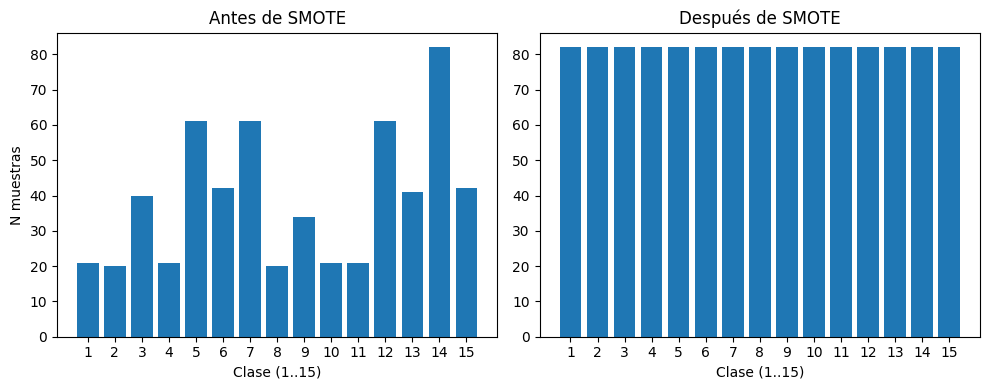

In [21]:
# Train / Test estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X_all,
    y_all,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_all
)

print("Distribución y_train (antes SMOTE):", np.bincount(y_train))

# SMOTE solo sobre entrenamiento
smote = SMOTE(random_state=RANDOM_STATE)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("Distribución y_train (después SMOTE):", np.bincount(y_train_sm))

# Gráficos de barras antes / después SMOTE con matplotlib
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].bar(np.arange(1, 16), np.bincount(y_train, minlength=15))
axes[0].set_title("Antes de SMOTE")
axes[0].set_xlabel("Clase (1..15)")
axes[0].set_ylabel("N muestras")
axes[0].set_xticks(np.arange(1, 16))

axes[1].bar(np.arange(1, 16), np.bincount(y_train_sm, minlength=15))
axes[1].set_title("Después de SMOTE")
axes[1].set_xlabel("Clase (1..15)")
axes[1].set_xticks(np.arange(1, 16))

plt.tight_layout()
plt.show()


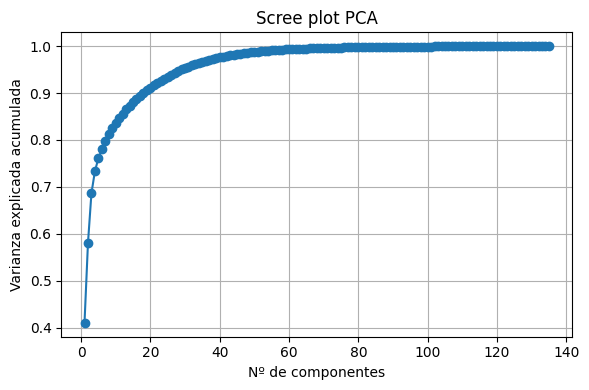

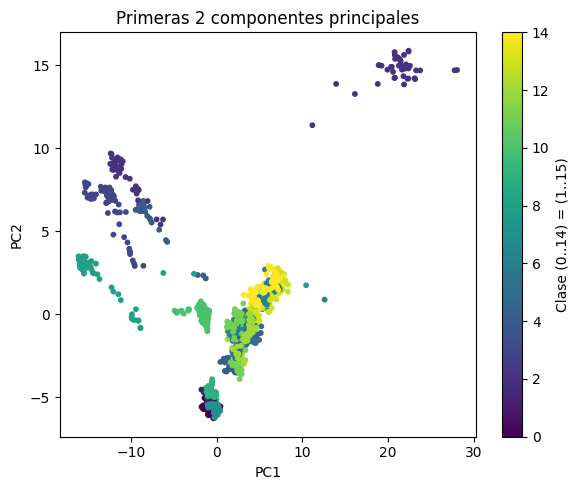

In [22]:
# Escalado + PCA para explorar varianza explicada
scaler_pca = StandardScaler()
X_train_sm_scaled = scaler_pca.fit_transform(X_train_sm)

pca_full = PCA()
X_train_pca_full = pca_full.fit_transform(X_train_sm_scaled)

explained = pca_full.explained_variance_ratio_

plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, len(explained) + 1),
         np.cumsum(explained),
         marker="o")
plt.xlabel("Nº de componentes")
plt.ylabel("Varianza explicada acumulada")
plt.title("Scree plot PCA")
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter 2D de las dos primeras componentes
plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    X_train_pca_full[:, 0],
    X_train_pca_full[:, 1],
    c=y_train_sm,
    s=10
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Primeras 2 componentes principales")
cbar = plt.colorbar(scatter)
cbar.set_label("Clase (0..14) = (1..15)")
plt.tight_layout()
plt.show()


In [23]:
def evaluar_modelo(nombre, modelo, X_train, y_train, X_test, y_test, labels=None):
    """
    Entrena el modelo, evalúa en test, imprime métricas y
    dibuja la matriz de confusión con matplotlib.
    """
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    print(f"\n============================")
    print(f"Modelo: {nombre}")
    print(f"Accuracy:          {acc:.4f}")
    print(f"F1 macro:          {f1_macro:.4f}")
    print(f"Balanced accuracy: {bal_acc:.4f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, digits=4))

    # Matriz de confusión
    if labels is None:
        labels = np.unique(np.concatenate([y_test, y_pred]))

    cm = confusion_matrix(y_test, y_pred, labels=labels)

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Matriz de confusión - {nombre}")
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, [l + 1 for l in labels], rotation=45)
    plt.yticks(tick_marks, [l + 1 for l in labels])
    plt.xlabel("Predicho")
    plt.ylabel("Real")

    # Anotar valores dentro de las celdas
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            cm[i, j],
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=8,
        )

    plt.tight_layout()
    plt.show()

    return {
        "modelo": nombre,
        "accuracy": acc,
        "f1_macro": f1_macro,
        "balanced_accuracy": bal_acc,
    }


In [24]:
def objective_rf(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 400)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )

    scores = cross_val_score(
        rf,
        X_train_sm,
        y_train_sm,
        cv=cv,
        scoring="f1_macro",
        n_jobs=-1,
    )
    return scores.mean()

study_rf = optuna.create_study(direction="maximize", study_name="RF_15clases")
study_rf.optimize(objective_rf, n_trials=N_TRIALS)

print("Mejores hiperparámetros RF:", study_rf.best_params)

rf_best = RandomForestClassifier(
    **study_rf.best_params,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)


[I 2025-11-16 13:14:11,856] A new study created in memory with name: RF_15clases
[I 2025-11-16 13:14:15,629] Trial 0 finished with value: 0.9690601751012011 and parameters: {'n_estimators': 364, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9690601751012011.
[I 2025-11-16 13:14:17,064] Trial 1 finished with value: 0.9689969979837153 and parameters: {'n_estimators': 116, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9690601751012011.
[I 2025-11-16 13:14:19,755] Trial 2 finished with value: 0.9600200535610088 and parameters: {'n_estimators': 378, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9690601751012011.
[I 2025-11-16 13:14:20,902] Trial 3 finished with value: 0.968997417316432 and parameters: {'n_estimators': 138, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9690601751012011.
[I 2025-11-16

Mejores hiperparámetros RF: {'n_estimators': 226, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1}


In [25]:
def objective_gb(trial):
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 2, 6)

    gb = GradientBoostingClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=RANDOM_STATE,
    )

    scores = cross_val_score(
        gb,
        X_train_sm,
        y_train_sm,
        cv=cv,
        scoring="f1_macro",
        n_jobs=-1,
    )
    return scores.mean()

study_gb = optuna.create_study(direction="maximize", study_name="GB_15clases")
study_gb.optimize(objective_gb, n_trials=N_TRIALS)

print("Mejores hiperparámetros GB:", study_gb.best_params)

gb_best = GradientBoostingClassifier(
    **study_gb.best_params,
    random_state=RANDOM_STATE,
)


[I 2025-11-16 13:14:28,713] A new study created in memory with name: GB_15clases
[I 2025-11-16 13:15:55,620] Trial 0 finished with value: 0.95368231187694 and parameters: {'learning_rate': 0.12824426898858532, 'n_estimators': 290, 'max_depth': 2}. Best is trial 0 with value: 0.95368231187694.
[I 2025-11-16 13:17:50,687] Trial 1 finished with value: 0.9494698490931996 and parameters: {'learning_rate': 0.08255395752730484, 'n_estimators': 237, 'max_depth': 4}. Best is trial 0 with value: 0.95368231187694.
[I 2025-11-16 13:20:35,966] Trial 2 finished with value: 0.9478861171318587 and parameters: {'learning_rate': 0.056184913668448626, 'n_estimators': 281, 'max_depth': 4}. Best is trial 0 with value: 0.95368231187694.
[I 2025-11-16 13:25:58,152] Trial 3 finished with value: 0.894238839391798 and parameters: {'learning_rate': 0.01452802069287702, 'n_estimators': 278, 'max_depth': 6}. Best is trial 0 with value: 0.95368231187694.
[I 2025-11-16 13:28:04,198] Trial 4 finished with value: 0.94

Mejores hiperparámetros GB: {'learning_rate': 0.263433307159412, 'n_estimators': 192, 'max_depth': 2}


In [26]:
def objective_knn(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 3, 25, step=2)
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])
    p = trial.suggest_int("p", 1, 2)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train_sm)

    knn = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        p=p,
    )

    scores = cross_val_score(
        knn,
        X_scaled,
        y_train_sm,
        cv=cv,
        scoring="f1_macro",
        n_jobs=-1,
    )
    return scores.mean()

study_knn = optuna.create_study(direction="maximize", study_name="KNN_15clases")
study_knn.optimize(objective_knn, n_trials=N_TRIALS)

print("Mejores hiperparámetros KNN:", study_knn.best_params)

# re-escalar todo train/test para usar KNN final
scaler_knn = StandardScaler().fit(X_train_sm)
X_train_knn = scaler_knn.transform(X_train_sm)
X_test_knn  = scaler_knn.transform(X_test)

knn_best = KNeighborsClassifier(**study_knn.best_params)


[I 2025-11-16 13:36:08,005] A new study created in memory with name: KNN_15clases
[I 2025-11-16 13:36:08,555] Trial 0 finished with value: 0.9113320314838507 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.9113320314838507.
[I 2025-11-16 13:36:08,723] Trial 1 finished with value: 0.9384235644021486 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.9384235644021486.
[I 2025-11-16 13:36:08,913] Trial 2 finished with value: 0.8493296637212016 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.9384235644021486.
[I 2025-11-16 13:36:09,107] Trial 3 finished with value: 0.936845908249126 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.9384235644021486.
[I 2025-11-16 13:36:09,279] Trial 4 finished with value: 0.9108100427904768 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'p': 1}. Best is tria

Mejores hiperparámetros KNN: {'n_neighbors': 9, 'weights': 'distance', 'p': 1}


In [27]:
def objective_svm(trial):
    C = trial.suggest_float("C", 0.1, 10.0, log=True)
    kernel = trial.suggest_categorical("kernel", ["rbf", "linear"])

    gamma = "scale"
    if kernel == "rbf":
        gamma = trial.suggest_float("gamma", 1e-4, 1e-1, log=True)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train_sm)

    svm = SVC(
        C=C,
        kernel=kernel,
        gamma=gamma,
    )

    scores = cross_val_score(
        svm,
        X_scaled,
        y_train_sm,
        cv=cv,
        scoring="f1_macro",
        n_jobs=-1,
    )
    return scores.mean()

study_svm = optuna.create_study(direction="maximize", study_name="SVM_15clases")
study_svm.optimize(objective_svm, n_trials=N_TRIALS)

print("Mejores hiperparámetros SVM:", study_svm.best_params)

# escalado final train/test
scaler_svm = StandardScaler().fit(X_train_sm)
X_train_svm = scaler_svm.transform(X_train_sm)
X_test_svm  = scaler_svm.transform(X_test)

svm_best = SVC(
    C=study_svm.best_params["C"],
    kernel=study_svm.best_params["kernel"],
    gamma=study_svm.best_params.get("gamma", "scale"),
)


[I 2025-11-16 13:36:10,140] A new study created in memory with name: SVM_15clases
[I 2025-11-16 13:36:10,218] Trial 0 finished with value: 0.9537557117305944 and parameters: {'C': 8.180467127352529, 'kernel': 'linear'}. Best is trial 0 with value: 0.9537557117305944.
[I 2025-11-16 13:36:10,372] Trial 1 finished with value: 0.9537557117305944 and parameters: {'C': 6.036474554127137, 'kernel': 'linear'}. Best is trial 0 with value: 0.9537557117305944.
[I 2025-11-16 13:36:10,582] Trial 2 finished with value: 0.9536875620732607 and parameters: {'C': 7.057013016288995, 'kernel': 'rbf', 'gamma': 0.023609861879990715}. Best is trial 0 with value: 0.9537557117305944.
[I 2025-11-16 13:36:10,768] Trial 3 finished with value: 0.9553042679314027 and parameters: {'C': 8.401418366214903, 'kernel': 'rbf', 'gamma': 0.03874988551250935}. Best is trial 3 with value: 0.9553042679314027.
[I 2025-11-16 13:36:10,974] Trial 4 finished with value: 0.6482504041362384 and parameters: {'C': 0.13740258107018166, 

Mejores hiperparámetros SVM: {'C': 8.401418366214903, 'kernel': 'rbf', 'gamma': 0.03874988551250935}


In [28]:
def objective_svm_pca(trial):
    C = trial.suggest_float("C", 0.1, 10.0, log=True)
    kernel = trial.suggest_categorical("kernel", ["rbf", "linear"])

    gamma = "scale"
    if kernel == "rbf":
        gamma = trial.suggest_float("gamma", 1e-4, 1e-1, log=True)

    n_components = trial.suggest_int(
        "n_components",
        10,
        min(X_train_sm.shape[1], 80)
    )

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train_sm)

    pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
    X_pca = pca.fit_transform(X_scaled)

    svm = SVC(
        C=C,
        kernel=kernel,
        gamma=gamma,
    )

    scores = cross_val_score(
        svm,
        X_pca,
        y_train_sm,
        cv=cv,
        scoring="f1_macro",
        n_jobs=-1,
    )
    return scores.mean()

study_svm_pca = optuna.create_study(direction="maximize", study_name="SVM_PCA_15clases")
study_svm_pca.optimize(objective_svm_pca, n_trials=N_TRIALS)

print("Mejores hiperparámetros SVM+PCA:", study_svm_pca.best_params)

# Escalado + PCA final para train/test
scaler_svm_pca = StandardScaler().fit(X_train_sm)
X_train_scaled = scaler_svm_pca.transform(X_train_sm)
X_test_scaled  = scaler_svm_pca.transform(X_test)

pca_svm = PCA(
    n_components=study_svm_pca.best_params["n_components"],
    random_state=RANDOM_STATE
).fit(X_train_scaled)

X_train_svm_pca = pca_svm.transform(X_train_scaled)
X_test_svm_pca  = pca_svm.transform(X_test_scaled)

svm_pca_best = SVC(
    C=study_svm_pca.best_params["C"],
    kernel=study_svm_pca.best_params["kernel"],
    gamma=study_svm_pca.best_params.get("gamma", "scale"),
)


[I 2025-11-16 13:36:12,080] A new study created in memory with name: SVM_PCA_15clases
[I 2025-11-16 13:36:12,299] Trial 0 finished with value: 0.4193518326247556 and parameters: {'C': 0.36305965469671814, 'kernel': 'rbf', 'gamma': 0.0001721292130109935, 'n_components': 30}. Best is trial 0 with value: 0.4193518326247556.
[I 2025-11-16 13:36:12,603] Trial 1 finished with value: 0.40497700591295543 and parameters: {'C': 0.33522284457718254, 'kernel': 'rbf', 'gamma': 0.00013261502147367997, 'n_components': 50}. Best is trial 0 with value: 0.4193518326247556.
[I 2025-11-16 13:36:12,981] Trial 2 finished with value: 0.9250799101463192 and parameters: {'C': 0.2926871126058783, 'kernel': 'linear', 'n_components': 33}. Best is trial 2 with value: 0.9250799101463192.
[I 2025-11-16 13:36:13,336] Trial 3 finished with value: 0.7408308594261027 and parameters: {'C': 0.10221230778275638, 'kernel': 'rbf', 'gamma': 0.014437020168320172, 'n_components': 30}. Best is trial 2 with value: 0.9250799101463

Mejores hiperparámetros SVM+PCA: {'C': 0.5668848339431889, 'kernel': 'linear', 'n_components': 49}



Modelo: RandomForest
Accuracy:          0.9388
F1 macro:          0.9333
Balanced accuracy: 0.9335

Classification report:
              precision    recall  f1-score   support

           0     0.8333    1.0000    0.9091         5
           1     0.8333    1.0000    0.9091         5
           2     1.0000    1.0000    1.0000        10
           3     1.0000    1.0000    1.0000         5
           4     1.0000    0.9375    0.9677        16
           5     0.7273    0.8000    0.7619        10
           6     1.0000    0.9375    0.9677        16
           7     1.0000    0.8000    0.8889         5
           8     1.0000    1.0000    1.0000         8
           9     1.0000    0.8000    0.8889         5
          10     1.0000    1.0000    1.0000         5
          11     0.9375    1.0000    0.9677        15
          12     0.8000    0.7273    0.7619        11
          13     0.9545    1.0000    0.9767        21
          14     1.0000    1.0000    1.0000        10

    accura

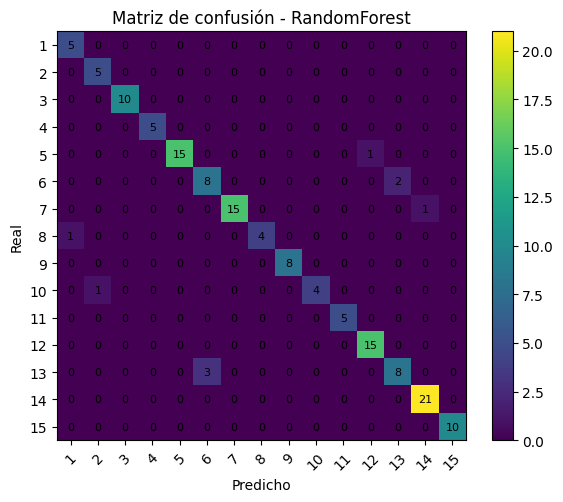


Modelo: GradientBoosting
Accuracy:          0.8776
F1 macro:          0.8522
Balanced accuracy: 0.8526

Classification report:
              precision    recall  f1-score   support

           0     0.8000    0.8000    0.8000         5
           1     0.7500    0.6000    0.6667         5
           2     1.0000    1.0000    1.0000        10
           3     1.0000    0.8000    0.8889         5
           4     0.8750    0.8750    0.8750        16
           5     0.8000    0.4000    0.5333        10
           6     1.0000    0.9375    0.9677        16
           7     0.5714    0.8000    0.6667         5
           8     1.0000    1.0000    1.0000         8
           9     0.8000    0.8000    0.8000         5
          10     1.0000    1.0000    1.0000         5
          11     0.8667    0.8667    0.8667        15
          12     0.6250    0.9091    0.7407        11
          13     0.9545    1.0000    0.9767        21
          14     1.0000    1.0000    1.0000        10

    ac

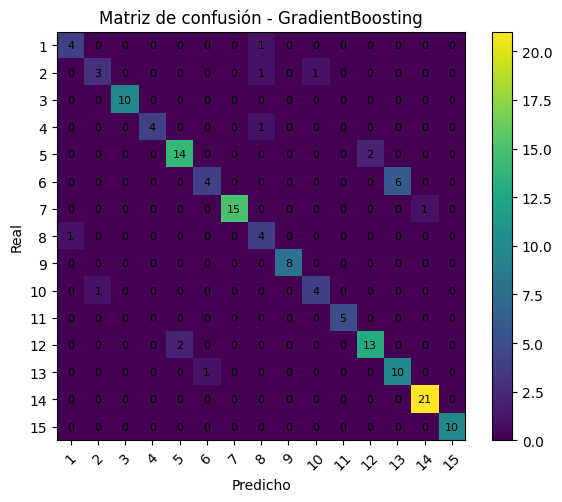


Modelo: KNN
Accuracy:          0.8367
F1 macro:          0.8071
Balanced accuracy: 0.8108

Classification report:
              precision    recall  f1-score   support

           0     1.0000    0.8000    0.8889         5
           1     0.3333    0.4000    0.3636         5
           2     1.0000    1.0000    1.0000        10
           3     1.0000    0.8000    0.8889         5
           4     1.0000    0.6875    0.8148        16
           5     0.7273    0.8000    0.7619        10
           6     0.7895    0.9375    0.8571        16
           7     0.8333    1.0000    0.9091         5
           8     1.0000    1.0000    1.0000         8
           9     0.2500    0.2000    0.2222         5
          10     0.8333    1.0000    0.9091         5
          11     0.7500    1.0000    0.8571        15
          12     0.8000    0.7273    0.7619        11
          13     0.9444    0.8095    0.8718        21
          14     1.0000    1.0000    1.0000        10

    accuracy       

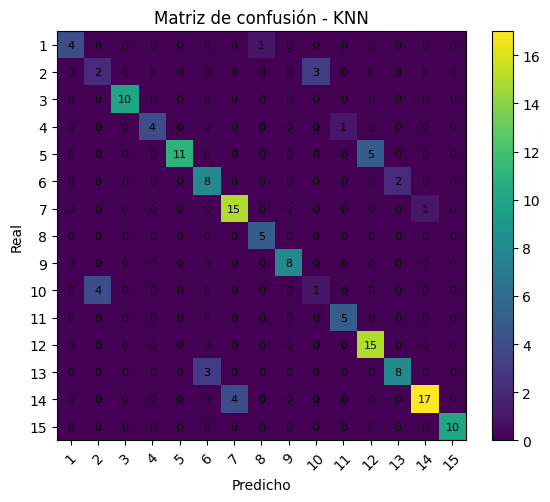


Modelo: SVM
Accuracy:          0.8231
F1 macro:          0.7897
Balanced accuracy: 0.7889

Classification report:
              precision    recall  f1-score   support

           0     1.0000    0.6000    0.7500         5
           1     0.4000    0.4000    0.4000         5
           2     0.8333    1.0000    0.9091        10
           3     1.0000    0.8000    0.8889         5
           4     0.6842    0.8125    0.7429        16
           5     0.7778    0.7000    0.7368        10
           6     0.9231    0.7500    0.8276        16
           7     0.7143    1.0000    0.8333         5
           8     1.0000    1.0000    1.0000         8
           9     0.2500    0.2000    0.2222         5
          10     1.0000    1.0000    1.0000         5
          11     0.8000    0.8000    0.8000        15
          12     0.7500    0.8182    0.7826        11
          13     0.9524    0.9524    0.9524        21
          14     1.0000    1.0000    1.0000        10

    accuracy       

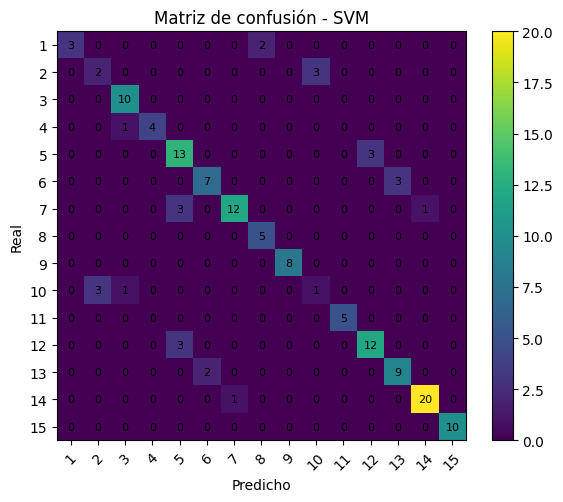


Modelo: SVM+PCA
Accuracy:          0.8299
F1 macro:          0.7951
Balanced accuracy: 0.7922

Classification report:
              precision    recall  f1-score   support

           0     0.7500    0.6000    0.6667         5
           1     0.4000    0.4000    0.4000         5
           2     0.9091    1.0000    0.9524        10
           3     1.0000    0.8000    0.8889         5
           4     0.7778    0.8750    0.8235        16
           5     0.8571    0.6000    0.7059        10
           6     0.9286    0.8125    0.8667        16
           7     0.6667    0.8000    0.7273         5
           8     1.0000    1.0000    1.0000         8
           9     0.4000    0.4000    0.4000         5
          10     1.0000    1.0000    1.0000         5
          11     0.8462    0.7333    0.7857        15
          12     0.7143    0.9091    0.8000        11
          13     0.8696    0.9524    0.9091        21
          14     1.0000    1.0000    1.0000        10

    accuracy   

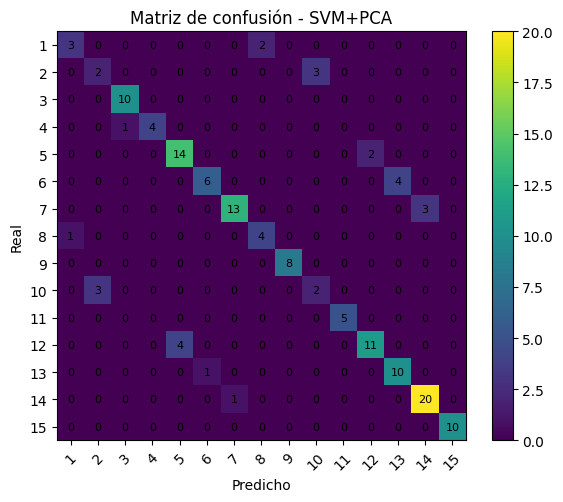


Tabla comparativa modelos clásicos:


,modelo,accuracy,f1_macro,balanced_accuracy
0,RandomForest,0.938776,0.933316,0.933485
1,GradientBoosting,0.877551,0.852163,0.852551
2,KNN,0.836735,0.807102,0.810786
3,SVM,0.823129,0.789721,0.788871
4,SVM+PCA,0.829932,0.795073,0.792154


In [29]:
import itertools

labels = np.arange(15)  # 0..14 (clases 1..15)
resultados = []

resultados.append(
    evaluar_modelo(
        "RandomForest",
        rf_best,
        X_train_sm,
        y_train_sm,
        X_test,
        y_test,
        labels=labels,
    )
)

resultados.append(
    evaluar_modelo(
        "GradientBoosting",
        gb_best,
        X_train_sm,
        y_train_sm,
        X_test,
        y_test,
        labels=labels,
    )
)

resultados.append(
    evaluar_modelo(
        "KNN",
        knn_best,
        X_train_knn,
        y_train_sm,
        X_test_knn,
        y_test,
        labels=labels,
    )
)

resultados.append(
    evaluar_modelo(
        "SVM",
        svm_best,
        X_train_svm,
        y_train_sm,
        X_test_svm,
        y_test,
        labels=labels,
    )
)

resultados.append(
    evaluar_modelo(
        "SVM+PCA",
        svm_pca_best,
        X_train_svm_pca,
        y_train_sm,
        X_test_svm_pca,
        y_test,
        labels=labels,
    )
)

df_resultados = pd.DataFrame(resultados)
print("\nTabla comparativa modelos clásicos:")
df_resultados


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0804 - loss: 65.5167 - val_accuracy: 0.0894 - val_loss: 12.3222
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1468 - loss: 14.7206 - val_accuracy: 0.1870 - val_loss: 2.9722
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1538 - loss: 6.0878 - val_accuracy: 0.1138 - val_loss: 2.4789
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1677 - loss: 3.9293 - val_accuracy: 0.0528 - val_loss: 2.6060
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1771 - loss: 3.1776 - val_accuracy: 0.0447 - val_loss: 2.6083
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1665 - loss: 3.1636 - val_accuracy: 0.0366 - val_loss: 2.6353
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1957 - loss: 2.8658 - val_accuracy: 0.0447 - val_loss: 2.6405
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2145 - loss: 2.6534 - val_accuracy: 0.0528 - val_l

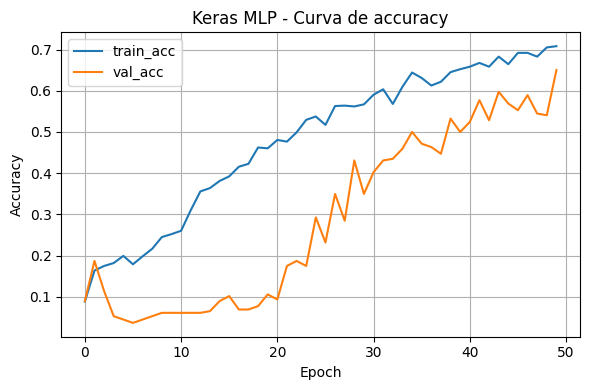


Keras MLP - Test accuracy: 0.5782
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


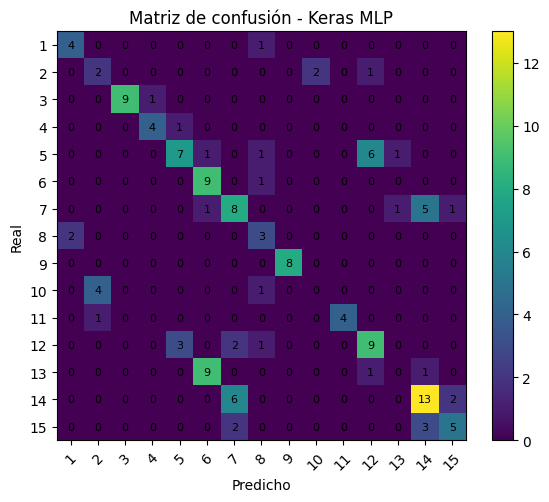


Tabla comparativa final (modelos clásicos + Keras):


,modelo,accuracy,f1_macro,balanced_accuracy
0,RandomForest,0.938776,0.933316,0.933485
1,GradientBoosting,0.877551,0.852163,0.852551
2,KNN,0.836735,0.807102,0.810786
3,SVM,0.823129,0.789721,0.788871
4,SVM+PCA,0.829932,0.795073,0.792154
5,Keras MLP,0.578231,0.564681,0.590437


In [30]:
num_classes = 15

# Pasar a numpy float32 para Keras
X_train_keras = X_train_sm.to_numpy(dtype=np.float32)
X_test_keras  = X_test.to_numpy(dtype=np.float32)

y_train_keras = to_categorical(y_train_sm, num_classes=num_classes)
y_test_keras  = to_categorical(y_test,    num_classes=num_classes)

model_keras = models.Sequential([
    layers.Input(shape=(X_train_keras.shape[1],)),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax"),
])

model_keras.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

history = model_keras.fit(
    X_train_keras,
    y_train_keras,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    verbose=1,
)

# Curvas de aprendizaje
plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Keras MLP - Curva de accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluación en test
test_loss, test_acc = model_keras.evaluate(X_test_keras, y_test_keras, verbose=0)
print(f"\nKeras MLP - Test accuracy: {test_acc:.4f}")

# Predicciones y matriz de confusión
y_pred_prob = model_keras.predict(X_test_keras)
y_pred_keras = np.argmax(y_pred_prob, axis=1)

res_keras = {
    "modelo": "Keras MLP",
    "accuracy": accuracy_score(y_test, y_pred_keras),
    "f1_macro": f1_score(y_test, y_pred_keras, average="macro"),
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_keras),
}

resultados.append(res_keras)

cm_keras = confusion_matrix(y_test, y_pred_keras, labels=labels)

plt.figure(figsize=(6,5))
plt.imshow(cm_keras, interpolation="nearest")
plt.title("Matriz de confusión - Keras MLP")
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, [l+1 for l in labels], rotation=45)
plt.yticks(tick_marks, [l+1 for l in labels])
plt.xlabel("Predicho")
plt.ylabel("Real")

for i, j in itertools.product(range(cm_keras.shape[0]), range(cm_keras.shape[1])):
    plt.text(
        j, i, cm_keras[i, j],
        horizontalalignment="center",
        verticalalignment="center",
        fontsize=8,
    )

plt.tight_layout()
plt.show()

# Actualizar tabla final con Keras
df_resultados = pd.DataFrame(resultados)
print("\nTabla comparativa final (modelos clásicos + Keras):")
df_resultados
